In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# --- 1. CORRECTED DATA LOADING ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['CANCER', 'NON CANCER']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(128, 128))
            image_array = img_to_array(image)
            image_array = preprocess_input(image_array) # Use the model-specific preprocessing
            images.append(image_array)
            labels.append(label)
            
    # CRITICAL FIX: DO NOT divide by 255. preprocess_input handles all necessary scaling.
    images = np.array(images, dtype="float32")
    labels = np.array(labels)
    return images, labels

# Load data
folder_path = "Oral Cancer/Oral Cancer Dataset"
images, labels = load_data(folder_path)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (750, 128, 128, 3)
Labels shape: (750,)


In [5]:
# Split data into train/validation and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
# Further split training data into train and validation (80-20 of the original 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (480, 128, 128, 3) (480,)
Validation shapes: (120, 128, 128, 3) (120,)
Test shapes: (150, 128, 128, 3) (150,)


In [6]:
# --- 2. DATA AUGMENTATION ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [7]:
# --- 3. MODEL BUILDING ---
# Load pretrained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Start with the entire base model frozen
base_model.trainable = False 

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
# --- 4. TWO-PHASE TRAINING ---

# === PHASE 1: Feature Extraction ===
print("\n--- PHASE 1: Training the Classifier Head ---")
model.compile(optimizer=Adam(learning_rate=1e-3), # Use a higher learning rate for the head
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
# We save the best model file
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

history_phase1 = model.fit(train_generator,
                           epochs=25, # Train for more epochs, EarlyStopping will handle it
                           validation_data=(X_val, y_val),
                           callbacks=[model_checkpoint, early_stopping, reduce_lr])


--- PHASE 1: Training the Classifier Head ---
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6906 - loss: 0.9515
Epoch 1: val_loss improved from None to 0.43622, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 824ms/step - accuracy: 0.7583 - loss: 0.7679 - val_accuracy: 0.8750 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8542 - loss: 0.5457
Epoch 2: val_loss improved from 0.43622 to 0.24696, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - accuracy: 0.8750 - loss: 0.3998 - val_accuracy: 0.8833 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8744 - loss: 0.3688
Epoch 3: val_loss improved from 0.24696 to 0.23456, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.8771 - loss: 0.3426 - val_accuracy: 0.9083 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9165 - loss: 0.2541
Epoch 4: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 631ms/step - accuracy: 0.9000 - loss: 0.2712 - val_accuracy: 0.8417 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8823 - loss: 0.2929
Epoch 5: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step - accuracy: 0.9000 - loss: 0.2483 - val_accuracy: 0.8750 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9227 - loss: 0.1929
Epoch 6: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - accuracy: 0.9271 - loss: 0.1836 - val_accuracy: 0.9250 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━

In [9]:
# === PHASE 2: Fine-Tuning ===
print("\n--- PHASE 2: Fine-Tuning the Top Layers ---")
base_model.trainable = True

# Unfreeze the top layers of the model
# Let's fine-tune from the last convolutional block
fine_tune_at = 143 # ResNet50 has 175 layers, 143 is start of the 5th block
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), # Re-compile with a VERY LOW learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_phase2 = model.fit(train_generator,
                           epochs=25,
                           validation_data=(X_val, y_val),
                           callbacks=[model_checkpoint, early_stopping, reduce_lr])


--- PHASE 2: Fine-Tuning the Top Layers ---
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7577 - loss: 0.5894
Epoch 1: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7979 - loss: 0.4917 - val_accuracy: 0.9250 - val_loss: 0.2395 - learning_rate: 1.0000e-05
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.8457 - loss: 0.3005
Epoch 2: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8583 - loss: 0.3014 - val_accuracy: 0.9000 - val_loss: 0.2495 - learning_rate: 1.0000e-05
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.8793 - loss: 0.2710
Epoch 3: val_loss did not improve from 0.23456
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 997ms/step - accuracy: 0.8813 - loss: 0.2677 - val_accuracy: 0.8917 - val_loss: 0.2544 - learning_rate: 1.0000e-05
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9252 - loss: 0.2017
Epoch 4: val_loss did not improve from

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9187 - loss: 0.2251 - val_accuracy: 0.9167 - val_loss: 0.2310 - learning_rate: 2.0000e-06
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.9007 - loss: 0.2419
Epoch 8: val_loss improved from 0.23095 to 0.22488, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - accuracy: 0.9104 - loss: 0.2174 - val_accuracy: 0.9250 - val_loss: 0.2249 - learning_rate: 2.0000e-06
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9340 - loss: 0.1843
Epoch 9: val_loss improved from 0.22488 to 0.22024, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 996ms/step - accuracy: 0.9167 - loss: 0.2335 - val_accuracy: 0.9333 - val_loss: 0.2202 - learning_rate: 2.0000e-06
Epoch 10/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9144 - loss: 0.2326
Epoch 10: val_loss improved from 0.22024 to 0.21653, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 969ms/step - accuracy: 0.9125 - loss: 0.2340 - val_accuracy: 0.9333 - val_loss: 0.2165 - learning_rate: 2.0000e-06
Epoch 11/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9395 - loss: 0.1590
Epoch 11: val_loss improved from 0.21653 to 0.21501, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 981ms/step - accuracy: 0.9375 - loss: 0.1573 - val_accuracy: 0.9333 - val_loss: 0.2150 - learning_rate: 2.0000e-06
Epoch 12/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9351 - loss: 0.1694
Epoch 12: val_loss improved from 0.21501 to 0.21415, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 987ms/step - accuracy: 0.9250 - loss: 0.1846 - val_accuracy: 0.9333 - val_loss: 0.2141 - learning_rate: 2.0000e-06
Epoch 13/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9076 - loss: 0.2340
Epoch 13: val_loss improved from 0.21415 to 0.21262, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 978ms/step - accuracy: 0.9250 - loss: 0.2009 - val_accuracy: 0.9333 - val_loss: 0.2126 - learning_rate: 2.0000e-06
Epoch 14/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9333 - loss: 0.2120
Epoch 14: val_loss improved from 0.21262 to 0.21201, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 964ms/step - accuracy: 0.9250 - loss: 0.2008 - val_accuracy: 0.9333 - val_loss: 0.2120 - learning_rate: 2.0000e-06
Epoch 15/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8928 - loss: 0.2440
Epoch 15: val_loss improved from 0.21201 to 0.21105, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8896 - loss: 0.2501 - val_accuracy: 0.9333 - val_loss: 0.2111 - learning_rate: 2.0000e-06
Epoch 16/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9216 - loss: 0.2157
Epoch 16: val_loss improved from 0.21105 to 0.20946, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9104 - loss: 0.2221 - val_accuracy: 0.9333 - val_loss: 0.2095 - learning_rate: 2.0000e-06
Epoch 17/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.9121 - loss: 0.2149
Epoch 17: val_loss improved from 0.20946 to 0.20827, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9125 - loss: 0.1994 - val_accuracy: 0.9333 - val_loss: 0.2083 - learning_rate: 2.0000e-06
Epoch 18/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.9313 - loss: 0.2076
Epoch 18: val_loss improved from 0.20827 to 0.20753, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9292 - loss: 0.2088 - val_accuracy: 0.9333 - val_loss: 0.2075 - learning_rate: 2.0000e-06
Epoch 19/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9438 - loss: 0.1514
Epoch 19: val_loss improved from 0.20753 to 0.20740, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9333 - loss: 0.1790 - val_accuracy: 0.9333 - val_loss: 0.2074 - learning_rate: 2.0000e-06
Epoch 20/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.8975 - loss: 0.2090
Epoch 20: val_loss improved from 0.20740 to 0.20646, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 986ms/step - accuracy: 0.9021 - loss: 0.1955 - val_accuracy: 0.9333 - val_loss: 0.2065 - learning_rate: 2.0000e-06
Epoch 21/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9100 - loss: 0.1938
Epoch 21: val_loss improved from 0.20646 to 0.20588, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9208 - loss: 0.1783 - val_accuracy: 0.9417 - val_loss: 0.2059 - learning_rate: 2.0000e-06
Epoch 22/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9590 - loss: 0.1543
Epoch 22: val_loss improved from 0.20588 to 0.20478, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 972ms/step - accuracy: 0.9292 - loss: 0.1935 - val_accuracy: 0.9417 - val_loss: 0.2048 - learning_rate: 2.0000e-06
Epoch 23/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9366 - loss: 0.1601
Epoch 23: val_loss improved from 0.20478 to 0.20386, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 982ms/step - accuracy: 0.9417 - loss: 0.1623 - val_accuracy: 0.9417 - val_loss: 0.2039 - learning_rate: 2.0000e-06
Epoch 24/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9249 - loss: 0.1842
Epoch 24: val_loss improved from 0.20386 to 0.20311, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 994ms/step - accuracy: 0.9312 - loss: 0.1673 - val_accuracy: 0.9417 - val_loss: 0.2031 - learning_rate: 2.0000e-06
Epoch 25/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.8981 - loss: 0.2029
Epoch 25: val_loss improved from 0.20311 to 0.20199, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9104 - loss: 0.2017 - val_accuracy: 0.9417 - val_loss: 0.2020 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 25.


In [10]:
# --- 5. EVALUATION ---
# Load the best weights saved by ModelCheckpoint
model.load_weights('best_model.h5')

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')


Test Accuracy: 87.33%
Test Loss: 0.3689


In [11]:
# CRITICAL FIX: Use thresholding for sigmoid output
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten() # Flatten for classification_report

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['NON CANCER (0)', 'CANCER (1)']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step

Classification Report:
                precision    recall  f1-score   support

NON CANCER (0)       0.90      0.91      0.91       100
    CANCER (1)       0.82      0.80      0.81        50

      accuracy                           0.87       150
     macro avg       0.86      0.85      0.86       150
  weighted avg       0.87      0.87      0.87       150



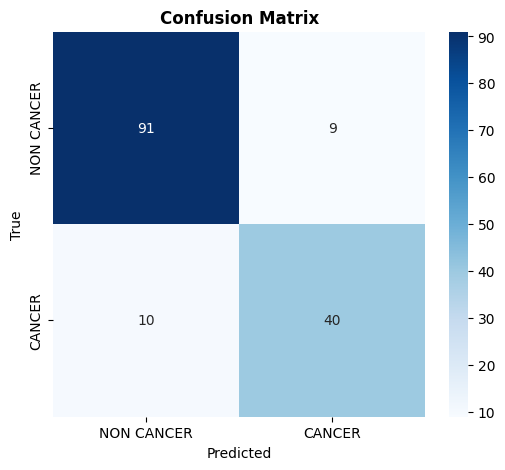

In [12]:
# Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NON CANCER', 'CANCER'], yticklabels=['NON CANCER', 'CANCER'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix',fontweight='bold')
plt.show()

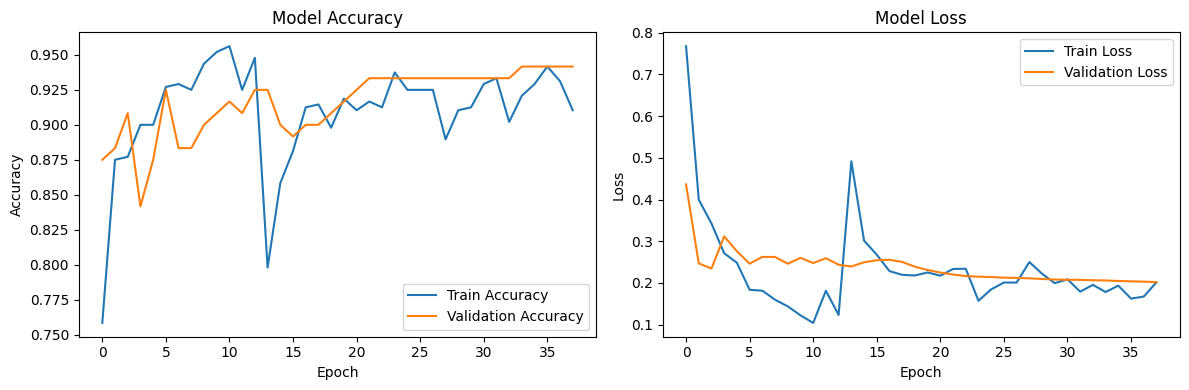

In [13]:
# --- Plotting Combined Results from Both Training Phases ---

# 1. Combine the history from both phases
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

# 2. Determine the epoch where fine-tuning started
# This will be the position for our vertical line
# transition_epoch = len(history_phase1.history['accuracy'])

# 3. Create the plots
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Add a vertical line to mark the start of fine-tuning
# plt.axvline(x=transition_epoch - 1, color='grey', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

# Add a vertical line to mark the start of fine-tuning
# plt.axvline(x=transition_epoch - 1, color='grey', linestyle='--', label='Start Fine-Tuning')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
# # Select 8 random images from the test set to visualize predictions
# rand_indexes = np.random.randint(0, X_test.shape[0], 8)
# print("\nRandom indexes from test set: ", rand_indexes)

# plt.figure(figsize=(11, 5))
# plt.suptitle('Sample Predictions on Test Data', fontweight='bold', fontsize=16)

# for i, index in enumerate(rand_indexes):
#     img = X_test[index]  # Already shape (128,128,3)
    
#     # Get true and predicted labels (binary case)
#     true_label = y_test[index]
#     predicted_label = y_pred_classes[index]
    
#     # Determine color of the title
#     color = 'green' if true_label == predicted_label else 'red'
    
#     plt.subplot(2, 4, i + 1)
#     plt.imshow(img)  # ✅ No reshape, and no cmap='gray' (it's RGB)
#     plt.title(f'True: {int(true_label)}\nPred: {int(predicted_label)}', color=color)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()



Random indexes from test set:  [143 133   6  60  55  33  17 120]


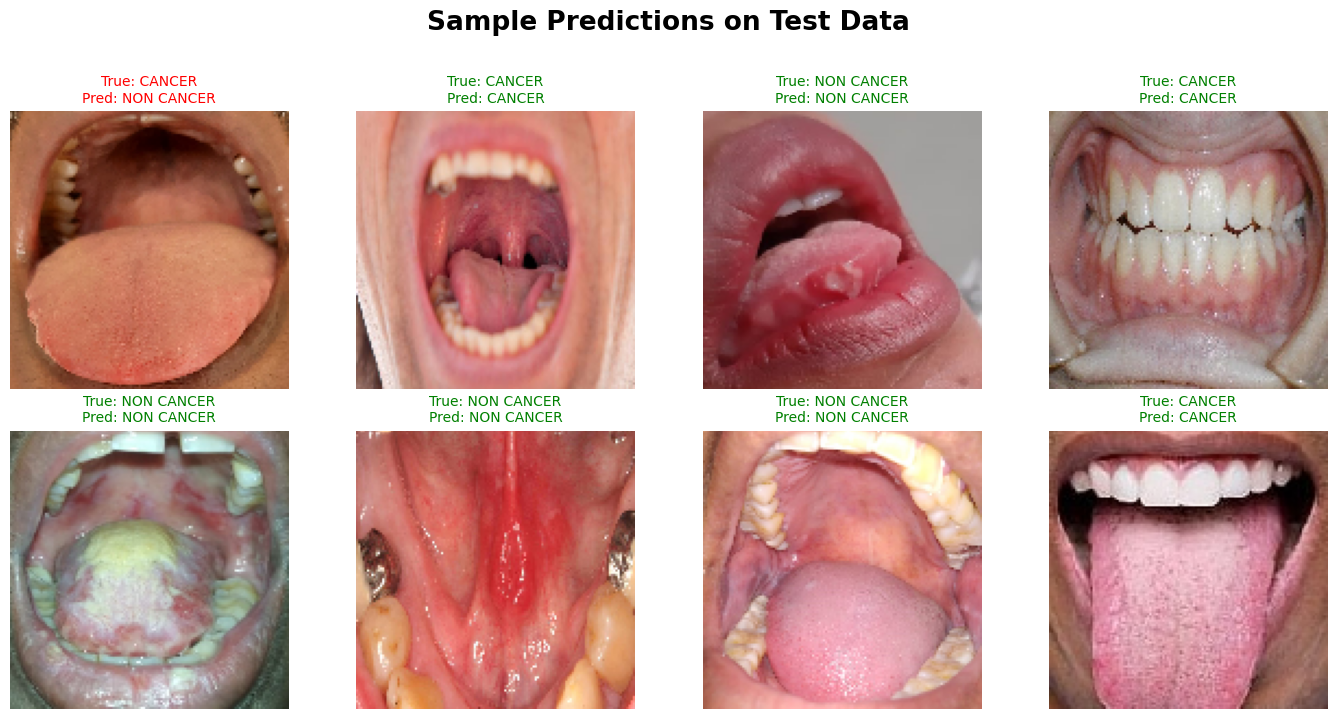

In [26]:
# --- Visualization of Predictions (Improved Image Quality) ---

# Select 8 random images from the test set to visualize predictions
rand_indexes = np.random.randint(0, X_test.shape[0], 8)
print("\nRandom indexes from test set: ", rand_indexes)

plt.figure(figsize=(14, 7)) # Slightly adjust figure size for better spacing
plt.suptitle('Sample Predictions on Test Data', fontweight='bold', fontsize=19, y=1.02) # Adjust suptitle position

# Define label names for clearer display
label_names = {0: 'NON CANCER', 1: 'CANCER'}

for i, index in enumerate(rand_indexes):
    # Get the preprocessed image from X_test
    preprocessed_img = X_test[index]
    
    # --- CRITICAL IMPROVEMENT: Reverse preprocess_input for display ---
    # This involves scaling and shifting the pixel values back to [0, 255]
    # For ResNet50's preprocess_input, it usually converts images from RGB to BGR,
    # then normalizes each color channel mean to 103.939, 116.779, 123.68 and its std to 1.
    # We need to reverse this.
    
    # Create a copy to avoid modifying X_test
    display_img = preprocessed_img.copy() 
    
    # If using ResNet50's preprocess_input which does BGR conversion and zero-centering:
    # Reverse the mean subtraction and channel order
    display_img[:, :, 0] += 103.939
    display_img[:, :, 1] += 116.779
    display_img[:, :, 2] += 123.68
    
    # Convert BGR to RGB (if preprocess_input did BGR conversion)
    # The [:, :, ::-1] slices the array to reverse the order of the last axis (channels)
    display_img = display_img[:, :, ::-1] 
    
    # Clip values to ensure they are within valid image range [0, 255] and convert to uint8
    display_img = np.clip(display_img, 0, 255).astype('uint8')
    # --- END CRITICAL IMPROVEMENT ---

    # Get true and predicted labels
    true_label = y_test[index]
    predicted_label = y_pred_classes[index]
    
    # Determine color of the title
    color = 'green' if true_label == predicted_label else 'red'
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(display_img) # Plot the 'de-preprocessed' image
    plt.title(f'True: {label_names[true_label]}\nPred: {label_names[predicted_label]}', 
              color=color, fontsize=10) # Use descriptive labels
    plt.axis('off')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.tight_layout()
plt.show()